In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [12]:
import seaborn as sns

In [13]:
sns.set_palette("colorblind")
%config InlineBackend.figure_format = "retina"

In [14]:
agents = ["LRKF", "FLoRES", "adamw", "LoFi", "muon"]
# agents = ["LRKF", "FLoRES", "adamw", "LoFi"]

In [15]:
def plot_rewards(rewards, color, **kwargs):
    rewards = pd.DataFrame(rewards)
    
    median = rewards.cumsum().mean(axis=1)
    lbound = rewards.cumsum().quantile(0.25, axis=1)
    ubound = rewards.cumsum().quantile(0.75, axis=1)
    
    median.plot(color=color, **kwargs)
    plt.fill_between(median.index, lbound, ubound, alpha=0.3, color=color)

In [42]:
def plot_rewards(rewards, hatch, color, **kwargs):
    rewards = pd.DataFrame(rewards)

    stat = rewards.expanding(min_periods=1000).mean()
    median = stat.mean(axis=1)
    lbound = stat.quantile(0.25, axis=1)
    ubound = stat.quantile(0.75, axis=1)
    
    median.plot(color=color, **kwargs)
    plt.fill_between(median.index, lbound, ubound, alpha=0.2, color=color, hatch=hatch)

In [ ]:
%%time
fig, ax = plt.subplots(figsize=(7.2, 4.2 * 0.6))

res_methods = {}

colors = sns.color_palette("tab20")
hatches = ["x", "o"]
for i, agent in enumerate(sorted(agents)):
    agent_path_eps = f"./output/{agent}_eps_5.pkl"
    agent_path_ts = f"./output/{agent}_ts.pkl"

    res = pd.read_pickle(agent_path_eps)
    plot_rewards(
        res["rewards"].T, label=rf"{agent}-$\epsilon$",
        color=colors[2 * i], hatch=hatches[i % 2]
    )

    res_methods[f"{agent}-es"] = {
        "reward": res["rewards"].sum(axis=1).mean(),
        "time": res["time"],
    }

    res = pd.read_pickle(agent_path_ts)
    plot_rewards(
        res["rewards"].T, label=f"{agent}-ts", linestyle="--",
        color=colors[2 * i  + 1], hatch=hatches[(2 * i  + 1) % 2]
    )

    res_methods[f"{agent}-ts"] = {
        "reward": res["rewards"].sum(axis=1).mean(),
        "time": res["time"],
    }
    
plt.legend(ncol=2, handlelength=1)
plt.xlabel("num. observations")
plt.ylabel("average reward")
plt.grid(alpha=0.3)
plt.savefig("../figures/mnist-bandit-reward.png", dpi=300, bbox_inches="tight")

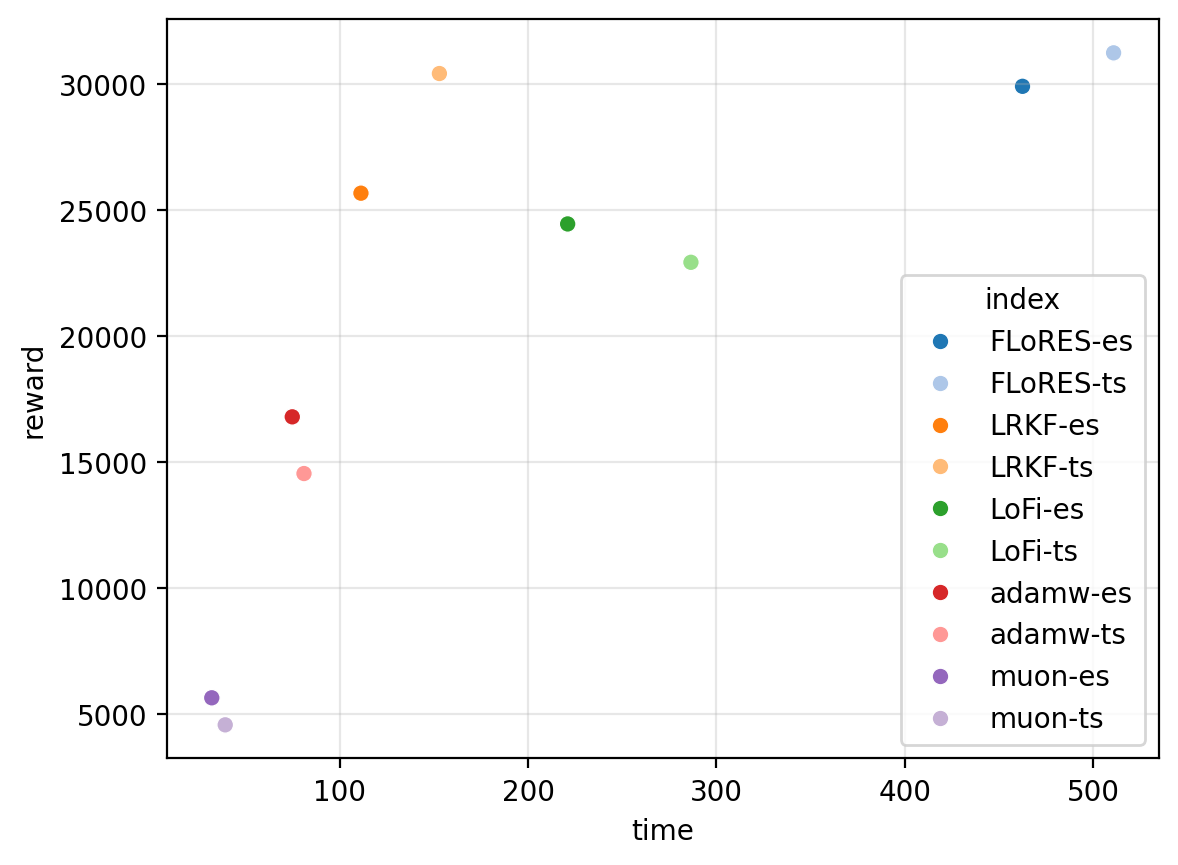

In [37]:
res_summary = pd.DataFrame.from_dict(res_methods, orient="index")

sns.scatterplot(
    x="time", y="reward", hue="index", data=res_summary.reset_index(),
    palette="tab20"
)
plt.grid(alpha=0.3)